Import Packages and Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# read-in the excel spreadsheet using pandas 
df = pd.read_excel('Online Retail.xlsx', sheet_name='Online Retail')

df.head() # take a look at the first 5 rows in the DataFrame

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Data Cleanup

In [3]:
# Drop cancelled orders
df = df.loc[df['Quantity'] > 0]

# Drop records without CustomerID
df = df[pd.notnull(df['CustomerID'])]

# Drop incomplete month
df = df.loc[df['InvoiceDate'] < '2011-12-01']

# Calculate total sales from the Quantity and UnitPrice
df['Sales'] = df['Quantity'] * df['UnitPrice']

Data Transformation

In [4]:
# use groupby to aggregate sales by CustomerID
customer_df = df.groupby('CustomerID').agg({'Sales': sum, 
                                            'InvoiceNo': lambda x: x.nunique()})

# Select the columns we want to use
customer_df.columns = ['TotalSales', 'OrderCount'] 

# create a new column 'AvgOrderValu'
customer_df['AvgOrderValue'] = customer_df['TotalSales'] / customer_df['OrderCount']

customer_df.head()


,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
12347.0,4085.18,6,680.863333
12348.0,1797.24,4,449.310000
12349.0,1757.55,1,1757.550000
12350.0,334.40,1,334.400000


Data Standardization

In [5]:
rank_df = customer_df.rank(method='first')
normalized_df = (rank_df - rank_df.mean()) / rank_df.std()
normalized_df.head(10)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,1.724999,-1.731446,1.731446
12347.0,1.457445,1.064173,1.401033
12348.0,0.967466,0.573388,0.929590
12349.0,0.944096,-1.730641,1.683093
12350.0,-0.732148,-1.729835,0.331622
12352.0,1.193114,1.309162,0.169639
12353.0,-1.636352,-1.729029,-1.570269
12354.0,0.508917,-1.728223,1.612981
12355.0,-0.386422,-1.727417,0.970690


Select the optimal number of clusters using Elbow curve method- Minimum Sum of Squared Error (SSE) where K is small

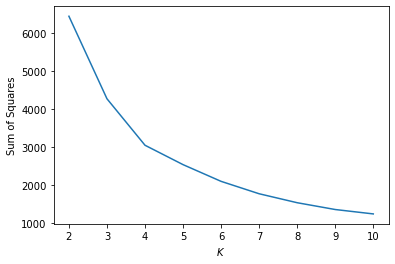

In [7]:
from sklearn import cluster
import numpy as np

sse = []
krange = list(range(2,11))
X = normalized_df[['TotalSales','OrderCount','AvgOrderValue']].values
for n in krange:
    model = cluster.KMeans(n_clusters=n, random_state=3)
    model.fit_predict(X)
    cluster_assignments = model.labels_
    centers = model.cluster_centers_
    sse.append(np.sum((X - centers[cluster_assignments]) ** 2))

plt.plot(krange, sse)
plt.xlabel("$K$")
plt.ylabel("Sum of Squares")
plt.show()

Interpreting Customer Segments

In [8]:
kmeans = KMeans(n_clusters=4).fit(normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']])

four_cluster_df = normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']].copy(deep=True)
four_cluster_df['Cluster'] = kmeans.labels_

four_cluster_df.head(10)

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,1.724999,-1.731446,1.731446,2
12347.0,1.457445,1.064173,1.401033,1
12348.0,0.967466,0.573388,0.929590,1
12349.0,0.944096,-1.730641,1.683093,2
12350.0,-0.732148,-1.729835,0.331622,2
12352.0,1.193114,1.309162,0.169639,1
12353.0,-1.636352,-1.729029,-1.570269,0
12354.0,0.508917,-1.728223,1.612981,2
12355.0,-0.386422,-1.727417,0.970690,2


let’s group the cluster metrics and see what we can gather from the normalized data for each cluster.

In [9]:
cluster1_metrics = kmeans.cluster_centers_[0]
cluster2_metrics = kmeans.cluster_centers_[1]
cluster3_metrics = kmeans.cluster_centers_[2]
cluster4_metrics = kmeans.cluster_centers_[3]

data = [cluster1_metrics, cluster2_metrics, cluster3_metrics, cluster4_metrics]
cluster_center_df = pd.DataFrame(data)

cluster_center_df.columns = four_cluster_df.columns[0:3]
cluster_center_df

,TotalSales,OrderCount,AvgOrderValue
0,-1.237648,-0.789031,-1.056409
1,1.204605,1.002443,0.870424
2,-0.134080,-0.846474,0.793249
3,0.233153,0.734378,-0.647511


Visualizing Clusters

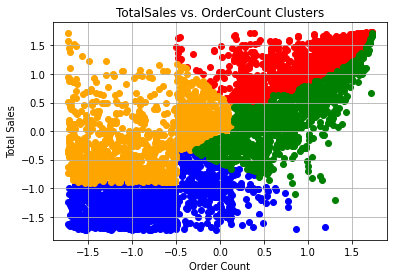

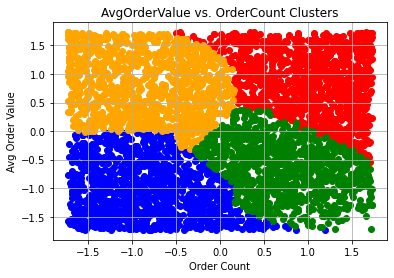

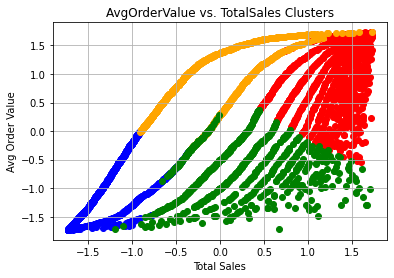

In [10]:
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'],
    c='blue')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'],
    c='red')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'],
    c='orange')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'],
    c='green')

plt.title('TotalSales vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Total Sales')

plt.grid()
plt.show()


plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c='blue')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c='red')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
    c='orange')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
    c='green')

plt.title('AvgOrderValue vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Avg Order Value')

plt.grid()
plt.show()


plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c='blue')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c='red')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
    c='orange')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
    c='green')

plt.title('AvgOrderValue vs. TotalSales Clusters')
plt.xlabel('Total Sales')
plt.ylabel('Avg Order Value')

plt.grid()
plt.show()

TotalSales vs. OrderCount Clusters

#Lowest Value Customers are in green: Low TotalSales and OrderCount Clusters


#Highest Value Customers are in Orange: High TotalSales and OrderCount Clusters

AvgOrderValue vs. OrderCount Clusters


#Lowest Value Customers are in green 


#Highest Value Customers are in Orange

AvgOrderValue vs. TotalSales Clusters

#Lowest Value Customers are in green 

#Highest Value Customers are in Orange

#Blue and red are High opportunity customers(from growth perspective they should be focused on)